# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
!pip install imageio pillow
import imageio
from PIL import Image
import datetime
import os
!pip install opencv-python
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers,regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Bidirectional,Conv2D,MaxPooling2D,Flatten,Dense,GRU,Conv3D,TimeDistributed,LSTM,Dense,Dropout,GlobalAveragePooling2D,MaxPooling3D,Flatten, Dense,Rescaling,Activation,BatchNormalization,Dropout,RandomFlip,RandomRotation
from tensorflow.keras.regularizers import l2
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras import optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(42)


In [3]:
##from google.colab import drive
#drive.mount('/content/drive')

In [16]:
import os

# List uploaded files
uploaded_files = os.listdir('/home/dl_content/Upgrad DL/Gesture Recognition Assignment')
print(uploaded_files)

# Verify the file extension
zip_file_path = '/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data.zip'  # Ensure this matches the uploaded file name
print(f"Checking file: {zip_file_path}")

# Check if the file is a valid ZIP file
import zipfile

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        print(f"File {zip_file_path} is a valid zip file.")
except zipfile.BadZipFile:
    print(f"File {zip_file_path} is not a valid zip file.")


['Starter_Code_Gesture_Recognition.ipynb', '.ipynb_checkpoints', 'Project_data.zip', 'Neural_Nets_Project_Starter_Code (6) (2).ipynb', 'Final_Neural_Nets_Project_Starter_Code_Final.ipynb', 'Replicate_Neural_Nets_Project_Starter_Code_Final.ipynb', 'Crop_Neural_Nets_Project_Code.ipynb', 'Project_data']
Checking file: /home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data.zip
File /home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data.zip is a valid zip file.


In [17]:
import shutil

zip_file_path = '/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data.zip'  # Adjust the filename if needed
if os.path.exists('/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data'):
  shutil.rmtree('/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data')
extracted_folder_path = '/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data/'  # You can change this to any folder name

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

print(f"Folder extracted to: {extracted_folder_path}")



Folder extracted to: /home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data/


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [18]:
train_doc = np.random.permutation(open('/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data/Project_data/val.csv').readlines())
batch_size = 32
#print(train_doc)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [19]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(30))   #create a list of image numbers you want to use for a particular video, incase if you want conclusion from 15 itself u can use 15
    while True:
        t = np.random.permutation(folder_list)

        num_batches = len(t) // batch_size # calculate the number of batches = 6
        #print(t=663)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,30,120,160,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_path = (source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    image = cv2.imread(image_path)

                    # Define the target size
                    target_height = 120
                    target_width = 160

                    # Get the original dimensions
                    original_height, original_width = image.shape[:2]
                    
                    # Check if the image is larger than the target size
                    if original_height >= target_height or original_width >= target_width:
                        # Resize the image to fit the target size (without distortion)
                        scale_width = target_width / original_width
                        scale_height = target_height / original_height
                        scale = min(scale_width, scale_height)  # Use the smaller scale factor
                        new_width = int(original_width * scale)
                        new_height = int(original_height * scale)
                        resized_image = cv2.resize(image, (target_width, target_height))
                        cv2.imwrite(image_path,resized_image)
                        image_array = np.array(resized_image)
                        batch_data[folder,idx,:,:,:] = image_array / 255.0
                    
                    else:
                        resized_image = cv2.resize(image, (target_width, target_height), interpolation=cv2.INTER_LINEAR)
                        cv2.imwrite(image_path,resized_image)
                        image_array = np.array(resized_image)

                        batch_data[folder,idx,:,:,:] = image_array / 255.0
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do



        ##code draw last thirteen folder images
        leftoverfoldersize = len(t) % batch_size
        folder2=t[-leftoverfoldersize:]
        for folderindex in range(leftoverfoldersize):
            imagelist=os.listdir(source_path+'/'+ folder2[folderindex].split(';')[0])
            for idx,item in enumerate(img_idx):
                image_path = (source_path+'/'+ folder2[folderindex].strip().split(';')[0]+'/'+imagelist[item])
                image = cv2.imread(image_path)

                # Define the target size
                target_height = 120
                target_width = 160

                # Get the original dimensions
                original_height, original_width = image.shape[:2]
                # Check if the image is larger than the target size
                if original_height > target_height or original_width > target_width:
                    # Resize the image to fit the target size (without distortion)
                    scale_width = target_width / original_width
                    scale_height = target_height / original_height
                    scale = min(scale_width, scale_height)  # Use the smaller scale factor
                    new_width = int(original_width * scale)
                    new_height = int(original_height * scale)
                    resized_image = cv2.resize(image, (target_width, target_height))
                    cv2.imwrite(image_path, resized_image)
                    image_array = np.array(resized_image)
                    batch_data[folder,idx,:,:,:] = image_array / 255.0


                else:
                    resized_image = cv2.resize(image, (target_width, target_height), interpolation=cv2.INTER_LINEAR)
                    cv2.imwrite(image_path,resized_image)
                    image_array = np.array(resized_image)
                    batch_data[folder,idx,:,:,:] = image_array / 255.0
                    
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

        yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

    


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [20]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data/Project_data/train'
val_path = '/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [21]:
train_generator=generator(train_path, train_doc, batch_size)
print(type(train_generator))
val_generator = generator(val_path, val_doc, batch_size)




    
   

<class 'generator'>


In [42]:
import gzip
import shutil
import os
from tensorflow.keras.callbacks import Callback

class ModelCheckpointCompression(Callback):
    def __init__(self, filepath):
        super().__init__()
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs=None):
        # Compress the checkpoint file after it is saved
        checkpoint_path = self.filepath.format(epoch=epoch + 1, **logs)
        
        if os.path.exists(checkpoint_path):
            # Compress the checkpoint file using gzip
            compressed_file = checkpoint_path + '.gz'
            with open(checkpoint_path, 'rb') as f_in:
                with gzip.open(compressed_file, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            print(f"Checkpoint compressed: {compressed_file}")
            
            # Optionally, remove the uncompressed checkpoint to save space
            os.remove(checkpoint_path)

# Define the model save path and the callback for compression
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# Add the custom compression callback
compression_callback = ModelCheckpointCompression(filepath)

# Use standard ModelCheckpoint to save the model normally
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# Use ReduceLROnPlateau for learning rate scheduling
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)

# Combine callbacks in a list
callbacks_list = [checkpoint, compression_callback, LR]


In [23]:


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Base Model with Conv3d

# training sequences = 663
# validation sequences = 100
# epochs = 20
<class 'generator'>
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 28, 118, 158, 32)  2624      
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 14, 59, 79, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_11 (Conv3D)          (None, 12, 57, 77, 64)    55360     
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 6, 28, 38, 64)    0         
 g3D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 408576)            0         
                              

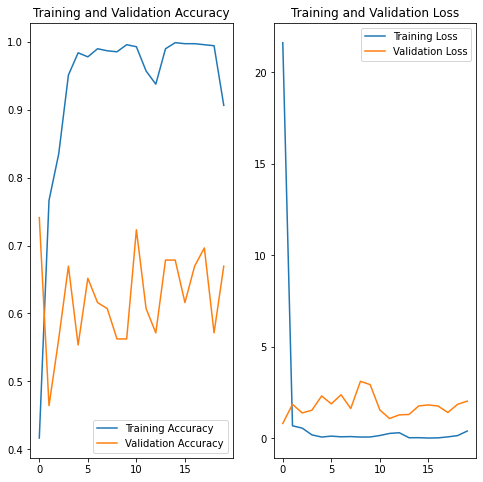

In [41]:
import gzip
import shutil
import os
from tensorflow.keras.callbacks import Callback

# Custom callback to save the model when val_accuracy > 75% and compress it
class SaveAndCompressModel(Callback):
    def __init__(self, filepath, target_accuracy=0.75):
        super(SaveAndCompressModel, self).__init__()
        self.filepath = filepath
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_categorical_accuracy')  # Get validation accuracy from logs
        if val_accuracy and val_accuracy > self.target_accuracy:
            print(f"\nEpoch {epoch + 1}: Validation Accuracy exceeded {self.target_accuracy * 100}%, saving and compressing model...")
            
            # Save the model
            model_filepath = self.filepath.format(epoch=epoch + 1, **logs)
            self.model.save(model_filepath)  # Save the model

            # Compress the model using gzip
            compressed_model_filepath = model_filepath + '.gz'
            with open(model_filepath, 'rb') as f_in:
                with gzip.open(compressed_model_filepath, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            print(f"Model saved and compressed as {compressed_model_filepath}")
            
            # Optionally, remove the uncompressed model to save space
            os.remove(model_filepath)

# Define the model save path
model_name = 'model_init_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Specify filepath for saving the model
filepath = model_name + 'model-{epoch:05d}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# Use the custom callback to save and compress the model when val_accuracy > 75%
save_and_compress_callback = SaveAndCompressModel(filepath)

# Use the ModelCheckpoint callback to save the best model based on validation loss
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto', save_weights_only=False, save_freq='epoch')

# Combine your custom callback and other callbacks
callbacks_list = [checkpoint, save_and_compress_callback]




batch_size=16

curr_dt_time = datetime.datetime.now()
train_path = '/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data/Project_data/train'
val_path = '/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)
train_generator=generator(train_path, train_doc, batch_size)
print(type(train_generator))
val_generator = generator(val_path, val_doc, batch_size)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


model1 = Sequential()
model1.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(30,120,160,3)))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))
model1.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))
model1.add(Flatten())
model1.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model1.add(Dense(5, activation='softmax'))
optimiser = 'adam'
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

 
history1=model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None,
           initial_epoch=0)



acc=history1.history['categorical_accuracy']
val_acc = history1.history['val_categorical_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

## Model -2 Will bUild model with CNN+RNN architecture

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 30, 118, 158, 32)  896      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 30, 59, 79, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 30, 57, 77, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 30, 28, 38, 64)   0         
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 30, 68096)       

2025-01-28 12:16:11.355549: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


21/21 [==============================] - ETA: 0s - loss: 1.9423 - categorical_accuracy: 0.2158
Epoch 00001: saving model to model_init_2025-01-2811_52_48.939002/model-00001-1.94231-0.21577-1.61503-0.24219.keras
Checkpoint compressed: model_init_2025-01-2811_52_48.939002/model-00001-1.94231-0.21577-1.61503-0.24219.keras.gz
21/21 [==============================] - 66s 3s/step - loss: 1.9423 - categorical_accuracy: 0.2158 - val_loss: 1.6150 - val_categorical_accuracy: 0.2422 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.6312 - categorical_accuracy: 0.1696
Epoch 00002: saving model to model_init_2025-01-2811_52_48.939002/model-00002-1.63116-0.16964-1.66388-0.21094.keras
Checkpoint compressed: model_init_2025-01-2811_52_48.939002/model-00002-1.63116-0.16964-1.66388-0.21094.keras.gz
21/21 [==============================] - 65s 3s/step - loss: 1.6312 - categorical_accuracy: 0.1696 - val_loss: 1.6639 - val_categorical_accuracy: 0.2109 - lr: 0.0010
Epoch 3/2

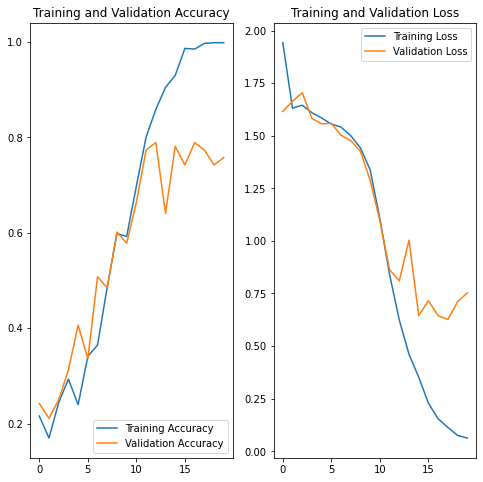

In [27]:
batch_size=32

curr_dt_time = datetime.datetime.now()
train_path = '/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data/Project_data/train'
val_path = '/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)
train_generator=generator(train_path, train_doc, batch_size)
print(type(train_generator))
val_generator = generator(val_path, val_doc, batch_size)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1




model2 = Sequential()

# Add CNN layers (feature extraction part)
model2.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(30, 120, 160, 3)))  # TimeDistributed wrapper to apply Conv2D on each frame
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

model2.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

model2.add(TimeDistributed(Flatten()))  # Flatten the features from each frame

# Add RNN layers (sequence modeling part)
model2.add(LSTM(128, return_sequences=False))  
model2.add(Dense(5, activation='softmax'))  


optimiser = 'adam'
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())


   
history2=model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None,
           initial_epoch=0)

acc=history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 3- Adding layers on BiDirectional LSTM CNN+RNN

# training sequences = 663
# validation sequences = 100
# epochs = 20
<class 'generator'>
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_21 (TimeDi  (None, 30, 118, 158, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 30, 59, 79, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 30, 57, 77, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 30, 28, 38, 64)   0         
 stributed)                                                      
                              

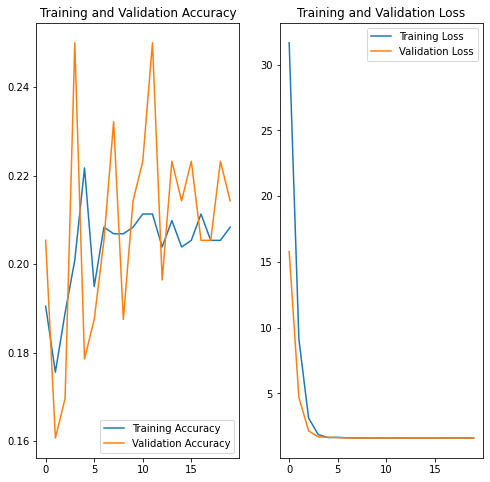

In [28]:
batch_size=16

curr_dt_time = datetime.datetime.now()
train_path = '/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data/Project_data/train'
val_path = '/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)
train_generator=generator(train_path, train_doc, batch_size)
print(type(train_generator))
val_generator = generator(val_path, val_doc, batch_size)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1






# Define the model
model3 = Sequential()

# Add CNN layers (feature extraction part)
model3.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(30, 120, 160, 3)))  # TimeDistributed wrapper to apply Conv2D on each frame
model3.add(TimeDistributed(MaxPooling2D((2, 2))))
#model3.add(Dropout(0.5))

model3.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))
#model3.add(Dropout(0.25))

model3.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))
#model3.add(Dropout(0.5))

model3.add(TimeDistributed(Flatten()))  # Flatten the features from each frame

# Add RNN layers (sequence modeling part)
#modellstm2.add(Bidirectional(LSTM(256, return_sequences=True))) 
#modellstm2.add(Dropout(0.05))

model3.add(Bidirectional(LSTM(128, return_sequences=True)))  
model3.add(Dropout(0.5))

#modellstm2.add(Bidirectional(LSTM(64,return_sequences=False,kernel_regularizer=regularizers.l2(0.05))))  
model3.add(Bidirectional(LSTM(64,return_sequences=False,kernel_regularizer=regularizers.l2(0.1))))  
model3.add(Dense(64, activation='relu')) 
model3.add(Dropout(0.5))

model3.add(Dense(5, activation='softmax'))  

optimiser = 'adam'
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())
    
history3 = model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None,
           initial_epoch=0)

acc=history3.history['categorical_accuracy']
val_acc = history3.history['val_categorical_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## MODEL 4 - with GRU

# training sequences = 663
# validation sequences = 100
# epochs = 20
<class 'generator'>
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_47 (TimeDi  (None, 30, 118, 158, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_48 (TimeDi  (None, 30, 59, 79, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 30, 57, 77, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 30, 28, 38, 64)   0         
 stributed)                                                      
                             

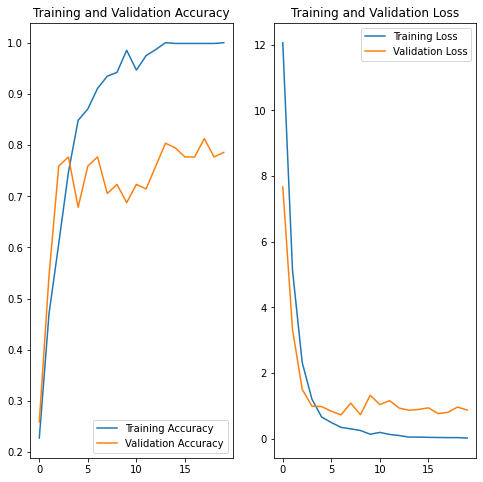

In [51]:
batch_size=16

curr_dt_time = datetime.datetime.now()
train_path = '/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data/Project_data/train'
val_path = '/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)
train_generator=generator(train_path, train_doc, batch_size)
print(type(train_generator))
val_generator = generator(val_path, val_doc, batch_size)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1






from tensorflow.keras import regularizers

from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed, GRU

# Define the model
model4 = Sequential()

# Add CNN layers (feature extraction part)
model4.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(30, 120, 160, 3)))  # TimeDistributed wrapper to apply Conv2D on each frame
model4.add(TimeDistributed(MaxPooling2D((2, 2))))
#modellstm2.add(Dropout(0.5))

model4.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))
#modellstm2.add(Dropout(0.25))

model4.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))
#modellstm2.add(Dropout(0.5))

model4.add(TimeDistributed(Flatten()))  # Flatten the features from each frame

# Add RNN layers (sequence modeling part)
#modellstm2.add(GRU(256, return_sequences=True)) 
#modellstm2.add(Dropout(0.05))

model4.add(GRU(128, return_sequences=True))
#modellstm2.add(Dropout(0.5))

#modellstm2.add(Bidirectional(LSTM(64,return_sequences=False,kernel_regularizer=regularizers.l2(0.05))))  
model4.add(GRU(64,return_sequences=False,kernel_regularizer=regularizers.l2(0.1)))  
model4.add(Dense(64, activation='relu')) 
#modellstm2.add(Dropout(0.5))

model4.add(Dense(5, activation='softmax'))  

optimiser = 'adam'
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())
    
history4 = model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None,
           initial_epoch=0)

acc=history4.history['categorical_accuracy']
val_acc = history4.history['val_categorical_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [37]:
##rm -rf ~/.local/share/Trash/*


## Model 5 - CNN+ RNN LSTM with dropout and kernel regulizer

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_17 (TimeDi  (None, 30, 120, 160, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 30, 120, 160, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 30, 60, 80, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 30, 60, 80, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 30, 60, 80, 32)  

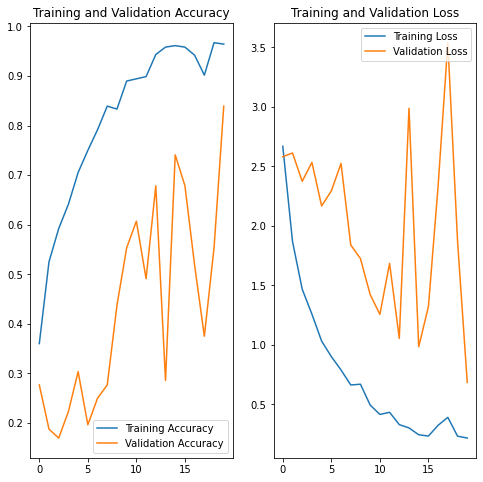

In [40]:
batch_size=16

curr_dt_time = datetime.datetime.now()
train_path = '/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data/Project_data/train'
val_path = '/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)
train_generator=generator(train_path, train_doc, batch_size)
print(type(train_generator))
val_generator = generator(val_path, val_doc, batch_size)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1




model5 = Sequential()

# TimeDistributed Conv2D layers
model5.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'), input_shape=(30, 120, 160, 3)))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

# Flattening the output for LSTM
model5.add(TimeDistributed(Flatten()))

# Ensure the LSTM layer gets 3D input (timesteps, features)
model5.add(LSTM(64, return_sequences=True))  # LSTM with 64 units, return sequences for the next LSTM layer
model5.add(Dropout(0.25))

model5.add(LSTM(64, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01)))  # L2 regularization
model5.add(Dropout(0.25))

# Fully connected Dense layers
model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.25))
model5.add(Dense(5, activation='softmax'))  # Assuming 5 classes

# Compile model
optimiser = 'adam'
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model summary
print(model5.summary())

history5 = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None,initial_epoch=0)

acc=history5.history['categorical_accuracy']
val_acc = history5.history['val_categorical_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 6 - Mobilenet with GRU

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 30, 3, 5, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 3, 5, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 1, 2, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 30, 2048)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 64)               

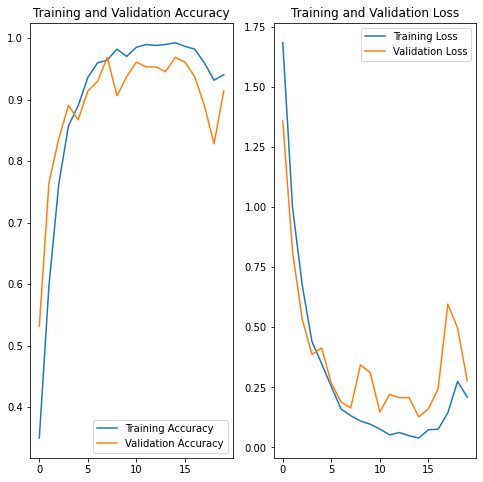

In [25]:
##batch_size=32

batch_size=32

curr_dt_time = datetime.datetime.now()
train_path = '/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data/Project_data/train'
val_path = '/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)
train_generator=generator(train_path, train_doc, batch_size)
print(type(train_generator))
val_generator = generator(val_path, val_doc, batch_size)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


    
from keras.applications import mobilenet




mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(120, 160, 3))

model6 = Sequential()
model6.add(TimeDistributed(mobilenet_transfer,input_shape=(30,120,160,3)))
 
        
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2, 2))))
model6.add(TimeDistributed(Flatten()))

model6.add(GRU(64))
model6.add(Dropout(0.5))
        
model6.add(Dense(64,activation='relu'))
model6.add(Dropout(0.5))
        
model6.add(Dense(5, activation='softmax'))
        
model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model6.summary())

history6 = model6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None,initial_epoch=0)


acc=history6.history['categorical_accuracy']
val_acc = history6.history['val_categorical_accuracy']

loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Model 7 - Resnet-50 with GRU

## Model 7 - Resnet-50 with GRU

##### Default batch_size 32 created OOM error , hence resized model to 16 running again. 

# training sequences = 663
# validation sequences = 100
# epochs = 20
<class 'generator'>
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeDi  (None, 30, 4, 5, 2048)   23587712  
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 30, 2048)         0         
 stributed)                                                      
                                                                 
 gru_3 (GRU)                 (None, 64)                405888    
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                              

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Checkpoint compressed: model_init_2025-01-2811_52_48.939002/model-00001-1.46608-0.40774-1.66729-0.16071.keras.gz
42/42 [==============================] - 67s 2s/step - loss: 1.4661 - categorical_accuracy: 0.4077 - val_loss: 1.6673 - val_categorical_accuracy: 0.1607 - lr: 1.0000e-04
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 0.7283 - categorical_accuracy: 0.7128
Epoch 00002: saving model to model_init_2025-01-2811_52_48.939002/model-00002-0.72829-0.71280-1.64175-0.26786.keras
Checkpoint compressed: model_init_2025-01-2811_52_48.939002/model-00002-0.72829-0.71280-1.64175-0.26786.keras.gz
42/42 [==============================] - 62s 1s/step - loss: 0.7283 - categorical_accuracy: 0.7128 - val_loss: 1.6417 - val_categorical_accuracy: 0.2679 - lr: 1.0000e-04
Epoch 3/20
42/42 [==============================] - ETA: 0s - loss: 0.4021 - categorical_accuracy: 0.8854
Epoch 00003: saving model to model_init_2025-01-2811_52_48.939002/model-00003-0.40211-0.88542-1.86157-0.22

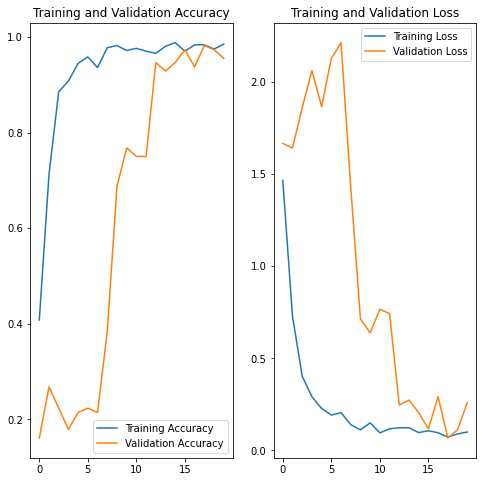

In [34]:
##Default batch size causing OOM error hence reducing batch size to 16
batch_size=16

curr_dt_time = datetime.datetime.now()
train_path = '/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data/Project_data/train'
val_path = '/home/dl_content/Upgrad DL/Gesture Recognition Assignment/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)
train_generator=generator(train_path, train_doc, batch_size)
print(type(train_generator))
val_generator = generator(val_path, val_doc, batch_size)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1



    
   


# Define the model
model7 = Sequential()

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(120, 160, 3))
model7.add(TimeDistributed(base_model, input_shape=(30, 120, 160, 3)))  # 30 frames in each video
model7.add(TimeDistributed(GlobalAveragePooling2D()))
model7.add(GRU(64, return_sequences=False))  # 64 units and not returning sequences
model7.add(Dropout(0.5))
model7.add(Dense(64, activation='relu'))
model7.add(Dropout(0.5))
model7.add(Dense(5, activation='softmax'))  # Change 5 to the number of classes you have
model7.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model summary to check the architecture
print(model7.summary())

history7 = model7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None,initial_epoch=0)

acc=history7.history['categorical_accuracy']
val_acc = history7.history['val_categorical_accuracy']

loss = history7.history['loss']
val_loss = history7.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

